## 使用gluon 进行冰川识别
kaggle 冰川比赛[链接](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from subprocess import check_output
from matplotlib import pyplot as plt

%matplotlib inline

## 加载数据，并显示数据

In [2]:
data_path = 'D:/dataset/kaggle_Iceberg/'
train_path = data_path + "train.json"
test_path  = data_path + "test.json"
train_json = pd.read_json(train_path)
test_json = pd.read_json(test_path)
train_json['inc_angle'] = pd.to_numeric(train_json['inc_angle'], errors='coerce')
test_json['inc_angle'] = pd.to_numeric(test_json['inc_angle'], errors='coerce')
print (len(train_json))

1604


In [3]:
print("Train Records")
train_json.head()


Train Records


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
print("Test Records")
test_json.head()

Test Records


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


## 数据增强部分
这里使用了skimage进行图像处理  
对训练数据进行随机裁剪和镜像

In [5]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction
# Isolation function.
def iso(arr):
    image = img_as_float(np.reshape(np.array(arr), [75,75]))
    image = gaussian_filter(image,2)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image 
    dilated = reconstruction(seed, mask, method='dilation')
    return image-dilated

# Feature engineering iso1 and iso2.
train_json['iso1'] = train_json.iloc[:, 0].apply(iso)
train_json['iso2'] = train_json.iloc[:, 1].apply(iso)

test_json['iso1'] = test_json.iloc[:, 0].apply(iso)
test_json['iso2'] = test_json.iloc[:, 1].apply(iso)

In [6]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.data import vision

def data_norm(data):
    images = []
    for i,row in data.iterrows():
        band_1 = np.reshape(np.array(row["band_1"]).astype(np.float32),(75,75))
        band_2 = np.reshape(np.array(row["band_2"]).astype(np.float32),(75,75))
        band_3 = (band_1+band_2)/2
        
        band_1_linear = np.power(10,np.array(band_1)/10)
        band_2_linear = np.power(10,np.array(band_2)/10)
        band_3_linear = np.power(10,np.array(band_3)/10)
        
        band_1_norm = (band_1_linear)/( band_1_linear.max()-band_1_linear.min())
        band_2_norm = (band_2_linear)/ (band_2_linear.max()-band_2_linear.min())
        band_3_norm = (band_3_linear)/ (band_3_linear.max()-band_3_linear.min())
        #band_3_norm = band_3 / band_3.max() 
        images.append(np.stack((band_1_norm,band_2_norm,band_3_norm)))
    return np.array(images)


train_augs = [
    image.HorizontalFlipAug(.5),
    image.CenterCropAug((32,32))
]

test_augs = [
    image.CenterCropAug((32,32))
]

def transform(img,augs):
    for f in augs:
        im=f(img)
    return im

def aug_img (data,aug_method,resize):
    dataset = data_norm(data)
    dataset = np.transpose(dataset, (0,3,2,1))
    dataset = nd.array(dataset)
    dataset_28 = nd.zeros(shape=(dataset.shape[0], resize, resize, 3))
    if aug_method == "train":
        for i in range(dataset.shape[0]):
            dataset_28[i,:]=transform(dataset[i,:],train_augs)
    elif aug_method == "test":
         for i in range(dataset.shape[0]):
                dataset_28[i,:]=transform(dataset[i,:],test_augs)  
    dataset_28.asnumpy()
    dataset_28 = np.transpose(dataset_28, (0,3,2,1))
    return dataset_28.asnumpy()

In [7]:
# 中心裁剪 32*32

X_train_total = aug_img(train_json,"train",32)
#X_train_total = data_norm(train_json)
y_train_total = np.array(train_json['is_iceberg'])
X_angle_train_total = np.array(train_json.inc_angle)

X_test = aug_img(test_json,"test",32)
#X_test = data_norm(test_json)
X_angle_test = np.array(test_json.inc_angle)


In [8]:
print X_train_total.shape
print (X_train_total.min(),X_train_total.max())

(1604L, 3L, 32L, 32L)
(4.51582e-07, 1.0753026)


## 显示经过处理后的图片

(1604L, 32L, 32L, 3L)


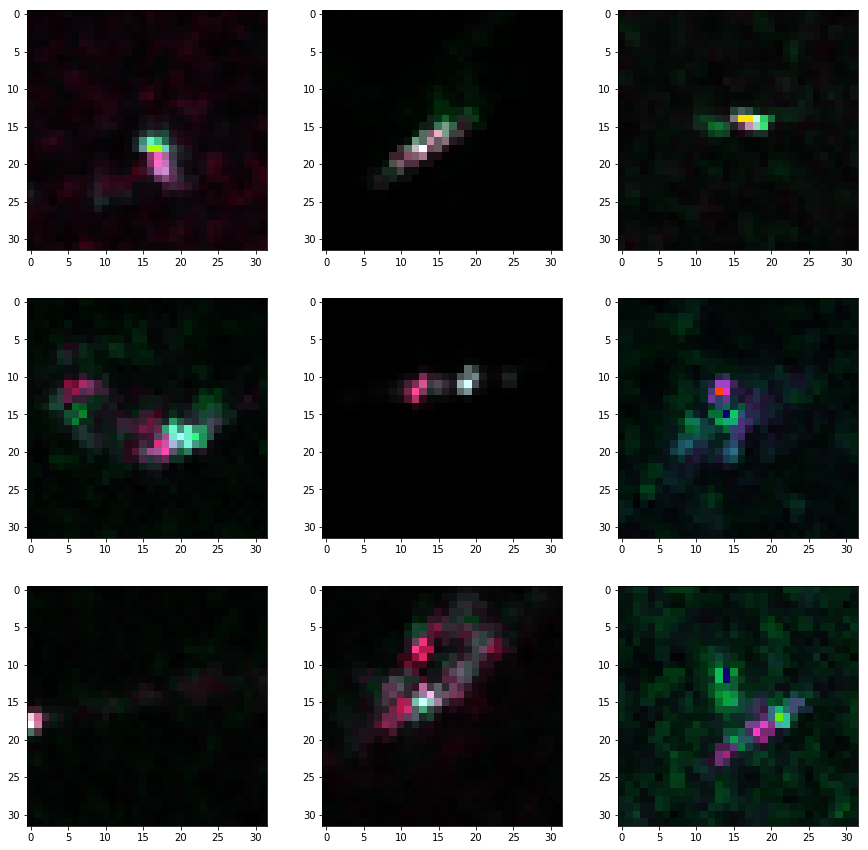

In [9]:
dataset = np.transpose(X_train_total, (0,3,2,1))
print dataset.shape
fig = plt.figure(2,figsize=(15,15))
p = 0

for i in range(3):
    for j in range(3):
        p+=1
        ax = fig.add_subplot(3,3,p)
        ax.imshow(dataset[p+100,:],cmap='jet')    
plt.show()

## 验证集

In [10]:
X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train_total
                    , X_angle_train_total, y_train_total, random_state=123, test_size=0.1)

    

y_test = np.zeros((X_test.shape[0],), dtype=np.int)

train_ds = gluon.data.ArrayDataset(X_train, y_train)
valid_ds = gluon.data.ArrayDataset(X_valid, y_valid)
train_valid_ds = gluon.data.ArrayDataset(X_train_total,y_train_total)
test_ds = gluon.data.ArrayDataset(X_test,y_test)

In [11]:
print X_train.shape

(1443L, 3L, 32L, 32L)


In [12]:
batch_size = 128
loader = gluon.data.DataLoader
train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep')
valid_data = loader(valid_ds, batch_size, shuffle=True, last_batch='keep')
train_valid_data= loader(train_valid_ds, batch_size, shuffle=True, last_batch='keep')
test_data = loader(test_ds,batch_size,shuffle = True,last_batch='keep')
# 交叉熵损失函数。
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### 训练模型


In [19]:
from mxnet.gluon import nn
from mxnet import nd

class Residual(nn.HybridBlock):
    def __init__(self, channels, same_shape=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1,
                                  strides=strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size=1,
                                      strides=strides)

    def hybrid_forward(self, F, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return F.relu(out + x)


class ResNet(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # 模块1
            net.add(nn.Conv2D(channels=32, kernel_size=3, strides=1, padding=1))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            # 模块2
            for _ in range(3):
                net.add(Residual(channels=32))
            # 模块3
            net.add(Residual(channels=64, same_shape=False))
            for _ in range(2):
                net.add(Residual(channels=64))
            # 模块4
            net.add(Residual(channels=128, same_shape=False))
            for _ in range(2):
                net.add(Residual(channels=128))
            # 模块5
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Dropout(0.5))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))

    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print('Block %d output: %s'%(i+1, out.shape))
        return out


def get_net(ctx):
    num_outputs = 2
    net = ResNet(num_outputs)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [20]:
net = ResNet(2, verbose=True)
net.initialize()

x = nd.random.uniform(shape=(4, 2, 32, 32))
y = net(x)

Block 1 output: (4L, 32L, 32L, 32L)
Block 2 output: (4L, 32L, 32L, 32L)
Block 3 output: (4L, 32L, 32L, 32L)
Block 4 output: (4L, 32L, 32L, 32L)
Block 5 output: (4L, 32L, 32L, 32L)
Block 6 output: (4L, 32L, 32L, 32L)
Block 7 output: (4L, 64L, 16L, 16L)
Block 8 output: (4L, 64L, 16L, 16L)
Block 9 output: (4L, 64L, 16L, 16L)
Block 10 output: (4L, 128L, 8L, 8L)
Block 11 output: (4L, 128L, 8L, 8L)
Block 12 output: (4L, 128L, 8L, 8L)
Block 13 output: (4L, 128L, 1L, 1L)
Block 14 output: (4L, 128L, 1L, 1L)
Block 15 output: (4L, 128L)
Block 16 output: (4L, 2L)


## 训练

In [21]:
import datetime
import sys
sys.path.append('..')
import utils
from matplotlib import pyplot as plt

def get_loss(data, net, ctx):
    loss = 0.0
    for feas, label in data:
        label = label.as_in_context(ctx)
        output = net(feas.as_in_context(ctx))
        cross_entropy = softmax_cross_entropy(output, label)
        loss += nd.mean(cross_entropy).asscalar()
    return loss / len(data)

def train(net, train_data, valid_data, num_epochs, lr, wd, ctx, lr_period,
          lr_decay):
    loss = 10
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9,
                                      'wd': wd})
    prev_time = datetime.datetime.now()
    plt_train_loss = []
    plt_valid_loss = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        if  epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
#         if epoch > 81 and epoch % 10 == 0:
#             trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for data, label in train_data:
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data.as_in_context(ctx))
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = get_loss(valid_data, net, ctx)
            epoch_str = ("Epoch %d. Train loss: %f, Valid loss %f, "
                         % (epoch, train_loss / len(train_data), valid_loss))
            plt_train_loss.append(train_loss / len(train_data))
            plt_valid_loss.append(valid_loss)
            
        else:
            epoch_str = ("Epoch %d. Train loss: %f, "
                         % (epoch, train_loss / len(train_data)))
        prev_time = cur_time
        if epoch % 10==0:
            print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))

    # plot 
    if valid_data is not None:
        plt.plot(plt_train_loss)
        plt.plot(plt_valid_loss)
        plt.legend(['train_loss','test_loss'])
        plt.savefig("Loss22.png")


Epoch 0. Train loss: 1.837689, Valid loss 0.803188, Time 00:00:01, lr 0.0001
Epoch 10. Train loss: 0.802196, Valid loss 0.674170, Time 00:00:01, lr 0.0001
Epoch 20. Train loss: 0.686978, Valid loss 0.558285, Time 00:00:01, lr 0.0001
Epoch 30. Train loss: 0.585850, Valid loss 0.605638, Time 00:00:01, lr 0.0001
Epoch 40. Train loss: 0.584826, Valid loss 0.530683, Time 00:00:01, lr 0.0001
Epoch 50. Train loss: 0.565585, Valid loss 0.572587, Time 00:00:01, lr 0.0001
Epoch 60. Train loss: 0.473982, Valid loss 0.525312, Time 00:00:01, lr 0.0001
Epoch 70. Train loss: 0.430538, Valid loss 0.541528, Time 00:00:01, lr 0.0001
Epoch 80. Train loss: 0.402553, Valid loss 0.546300, Time 00:00:01, lr 0.0001
Epoch 90. Train loss: 0.353119, Valid loss 0.579709, Time 00:00:01, lr 0.0001
Epoch 100. Train loss: 0.295127, Valid loss 0.588309, Time 00:00:01, lr 1e-05
Epoch 110. Train loss: 0.290103, Valid loss 0.520813, Time 00:00:01, lr 1e-05
Epoch 120. Train loss: 0.317673, Valid loss 0.636149, Time 00:00:

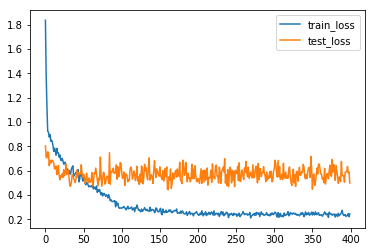

In [22]:
from mynet import *
from vggnet import *

ctx = utils.try_gpu()
num_epochs = 400
learning_rate = 0.001
weight_decay = 1e-4
lr_period = 100
lr_decay = .1

# net = get_simple_net(ctx)
net = get_net(ctx)
#net = get_simple_net(ctx,"mynet")
#net  = vgg_net(ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate,weight_decay, ctx, lr_period, lr_decay)

In [ ]:
import numpy as np


net = get_simple_net(ctx,"mymode")
net.hybridize()
train(net, train_valid_data, None, num_epochs, learning_rate, weight_decay,
      ctx, lr_period, lr_decay)

### 使用训练好的模型对测试样本进行预测，并保存文本

In [ ]:
outputs = []
for data, label in test_data:
    output = nd.softmax(net(data.as_in_context(ctx)))
    outputs.extend(output.asnumpy())

In [ ]:
test_pre = []

for num in outputs:
    test_pre.append(num[1])
print (len(test_pre)==8424)

In [ ]:
submission = pd.DataFrame({'id': test_json["id"], 'is_iceberg': test_pre})
submission.to_csv("submission.csv", index=False)